March Madness Men's Results
==============================

This notebook will explore predictions for the 2024 March Madness tournament and before, based on Massey rankings and tournament seeding. The purpose is to create a model for predicting tournament performance that can be applied to the 2025 teams.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn.ensemble as en
import sklearn.model_selection as mds
import sklearn.metrics as ms
import sklearn.preprocessing as pre

from scipy import interpolate

### CONSTANTS ###

DATA_DIR = '../data/kaggle/'

SYSTEM_NAME = [ "MAS" ]
RANKING_DAYS = [ 133 ]
YEARS = [ 2024 ]

RANK_DAY_COL = SYSTEM_NAME[0] + "_" + str(YEARS[0]) + "_" + str(RANKING_DAYS[0])

### FUNCTIONS ###

def extract_seed_value(seed_str):
    try:
        return int(seed_str[1:])
    except:
        np.nan

def get_cross_game_id(row):
    season = int(row["Season"])
    team_x1 = int(row["TeamID_X1"])
    team_x2 = int(row["TeamID_X2"])

    return f"{season}_{team_x1}_{team_x2}"

def get_tournament_game_id(row):
    season = int(row["Season"])
    team_w = int(row["WTeamID"])
    team_l = int(row["LTeamID"])

    if team_w >= team_l:
        return f"{season}_{team_l}_{team_w}"
    else:
        return f"{season}_{team_w}_{team_l}"

def extract_game_info(id_str):

    # Extract year and team_ids
    parts = id_str.split('_')
    year = int(parts[0])
    teamID1 = int(parts[1])
    teamID2 = int(parts[2])
    return year, teamID1, teamID2

def does_team1_win(row):

    y, team1, team2 = extract_game_info(row["GameID"])
    if row["WTeamID"] == team1:
        return 1
    else:
        return 0

def load_mens_and_womens( filename ):

    df_m_ = pd.read_csv( DATA_DIR + "M" + filename )
    df_m_["Gender"] = "M"
    
    #df_w_ = pd.read_csv( DATA_DIR + "W" + filename )
    #df_w_["Gender"] = df_w_["Season"].astype(str) + "W"
    
    #df_concat = pd.concat([ df_m_, df_w_ ])
    
    return df_m_

# Load Team Data and Rankings

Start by loading the seed data for the season(s) listed in the YEARS array, expected to be 68 teams. For now, this notebook is focused on the men's results, to keep the datasets small for initial exploration. Once the model is created, it should be relatively trivial to add results for the women's tournament.

In [2]:
df_ = pd.read_csv( DATA_DIR + "MNCAATourneySeeds.csv")
df_seeds = df_[ df_["Season"].isin( YEARS ) ]
df_seeds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 2490 to 2557
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  68 non-null     int64 
 1   Seed    68 non-null     object
 2   TeamID  68 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ KB


Next, load the Massey rankings for the same set of seasons. For initial exploration, this notebook is only concerned with the most recent results of a single system ("Massey BCS") before the tournament. Future exploration could include other rankings.

In [3]:
df_ = pd.read_csv( DATA_DIR + "MMasseyOrdinals.csv" )

num_days = 5
last_ranking_day = {}
df_massey = pd.DataFrame()

for y in YEARS:

    df_year = df_[ df_[ "Season" ] == y ].copy()
    last_ranking_days = df_year[ "RankingDayNum" ].unique()[-num_days:]

    df_sub = df_year[ ( df_year[ "RankingDayNum" ].isin( RANKING_DAYS ) ) & \
                      ( df_year[ "SystemName" ].isin( SYSTEM_NAME ) ) ].copy()

    days_str = ', '.join(str(x) for x in last_ranking_days)
    print(f"Last {num_days} ranking days of {y} season are {days_str}")

    df_sub[ "SysRankDay" ] = df_sub["SystemName"] + "_" + df_sub["Season"].astype(str) \
                           + "_" + df_sub["RankingDayNum"].astype(str)
    df_sub = df_sub.set_index(["TeamID", "SysRankDay"])[["OrdinalRank"]]
    df_sub = df_sub.unstack(level=0).T

    df_sub[ "Season" ] = y
    df_sub[ "Gender" ] = "M"
    #df_sub = df_sub.reset_index(level=[1])

    df_sub.reset_index(level='TeamID', inplace=True)
    
    if df_massey.empty:
        df_massey = df_sub
    else:
        df_massey = pd.concat( [df_massey, df_sub] )

df_massey = df_massey.reset_index(drop=True)
df_massey.fillna(0, inplace=True)

Last 5 ranking days of 2024 season are 107, 114, 121, 128, 133


In [4]:
df_massey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TeamID        362 non-null    int64 
 1   MAS_2024_133  362 non-null    int64 
 2   Season        362 non-null    int64 
 3   Gender        362 non-null    object
dtypes: int64(3), object(1)
memory usage: 11.4+ KB


Merge the Massey rankings with the seed data, so that anything that doesn't have a "Seed" value is marked as n/a.

In [5]:
df_teams = df_massey.merge( df_seeds, on=['TeamID', 'Season'], how='left' )
df_teams.tail()

,TeamID,MAS_2024_133,Season,Gender,Seed
357,1474,264,2024,M,NaN
358,1475,346,2024,M,NaN
359,1476,359,2024,M,NaN
360,1477,325,2024,M,NaN
361,1478,322,2024,M,NaN


Merge team names into the dataframe, for ease of reading.

In [6]:
df_teams_details = pd.read_csv( DATA_DIR + "MTeams.csv" )

df_teams = df_teams.merge( df_teams_details, on=['TeamID' ], how='left' )
df_teams['SeedValue'] = df_teams['Seed'].apply(extract_seed_value)

df_teams['OrdinalRank'] = df_teams[ RANK_DAY_COL ]

df_teams.head()

,TeamID,MAS_2024_133,Season,Gender,Seed,TeamName,FirstD1Season,LastD1Season,SeedValue,OrdinalRank
0,1101,189,2024,M,NaN,Abilene Chr,2014,2025,NaN,189
1,1102,249,2024,M,NaN,Air Force,1985,2025,NaN,249
2,1103,104,2024,M,Y14,Akron,1985,2025,14.0,104
3,1104,16,2024,M,X04,Alabama,1985,2025,4.0,16
4,1105,328,2024,M,NaN,Alabama A&M,2000,2025,NaN,328


# Create Hypothetical Matchups

This section will turn the list of 362 teams for the men's season into 65K hypothetical matchups, which we can then use to predict the overall outcomes of the 2024 tournament.

In [7]:
df_cross = pd.DataFrame()

for y in YEARS:

    df_year = df_teams[( df_teams[ "Season" ] == y )]
    
    df_teams_sub = df_year[[ "TeamID", "TeamName", "OrdinalRank", "Seed", "SeedValue", "Season" ]]
    cross_teams = pd.merge( df_teams_sub, df_teams_sub, how="cross", suffixes=["_X1", "_X2"] )

    cross_teams.drop( "Season_X2", axis=1, inplace=True )
    cross_teams.rename( columns={ "Season_X1": "Season" }, inplace=True )

    if df_cross.empty:
        df_cross = cross_teams
    else:
        df_cross = pd.concat( [df_cross, cross_teams] )

df_cross.shape

(131044, 11)

Per the expected submissions data, any rows where TeamID_X1 >= TeamID_X2 are dropped. For the 2025 season, this _should_ provide a total of 131407 rows (men's and women's teams) and a header in the submissions dataset.

In [8]:
df_cross = df_cross.drop( df_cross[ df_cross["TeamID_X1"] >= df_cross["TeamID_X2"] ].index )

Run final processing on the cross-team merge, including calculating diffs in rankings between teams, and setting the game id.

In [9]:
df_cross["RankDiff"] = df_cross["OrdinalRank_X1"] - df_cross["OrdinalRank_X2"]
df_cross["SeedDiff"] = df_cross["SeedValue_X1"] - df_cross["SeedValue_X2"]
df_cross["GameID"] = df_cross.apply( get_cross_game_id, axis=1 )

df_cross["SeedDiff"] = df_cross["SeedDiff"].fillna(0)

df_cross.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65341 entries, 1 to 130681
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TeamID_X1       65341 non-null  int64  
 1   TeamName_X1     65341 non-null  object 
 2   OrdinalRank_X1  65341 non-null  int64  
 3   Seed_X1         13068 non-null  object 
 4   SeedValue_X1    11361 non-null  float64
 5   Season          65341 non-null  int64  
 6   TeamID_X2       65341 non-null  int64  
 7   TeamName_X2     65341 non-null  object 
 8   OrdinalRank_X2  65341 non-null  int64  
 9   Seed_X2         11480 non-null  object 
 10  SeedValue_X2    10299 non-null  float64
 11  RankDiff        65341 non-null  int64  
 12  SeedDiff        65341 non-null  float64
 13  GameID          65341 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 7.5+ MB


Show the hypothetical matchups for a team that usually gets ranked. This notebook assumes "TeamName_X2" will only have teams that come after Gonzaga in the alphabet.

In [10]:
df_gonzaga = df_cross[ df_cross["TeamName_X1"] == "Gonzaga" ].copy()
df_gonzaga[["GameID", "TeamName_X1", "TeamName_X2", "RankDiff", "SeedDiff"]].head(5).style.hide(axis="index")

GameID,TeamName_X1,TeamName_X2,RankDiff,SeedDiff
2024_1211_1212,Gonzaga,Grambling,-256,0.000000
2024_1211_1213,Gonzaga,Grand Canyon,-47,-7.000000
2024_1211_1214,Gonzaga,Hampton,-319,0.000000
2024_1211_1217,Gonzaga,Harvard,-187,0.000000
2024_1211_1218,Gonzaga,Hawaii,-163,0.000000


# Load Tournament Results

In [11]:
df_ = pd.read_csv( DATA_DIR + "MNCAATourneyCompactResults.csv" )

df_tourney = df_[ df_["Season"].isin( YEARS ) ].copy()

df_tourney["GameID"] = df_tourney.apply( get_tournament_game_id, axis=1 )
df_tourney["Team1Win"] = df_tourney.apply( does_team1_win, axis=1 )

df_tourney.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 2451 to 2517
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Season    67 non-null     int64 
 1   DayNum    67 non-null     int64 
 2   WTeamID   67 non-null     int64 
 3   WScore    67 non-null     int64 
 4   LTeamID   67 non-null     int64 
 5   LScore    67 non-null     int64 
 6   WLoc      67 non-null     object
 7   NumOT     67 non-null     int64 
 8   GameID    67 non-null     object
 9   Team1Win  67 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 5.8+ KB


# Merge Tournament Results with Predictions

To help better analyze the data, we will be cleaning and pre-processing the 2024 results, as well as incorporating seed values and Massey rankings.

In [12]:
df_merged = df_tourney.merge(df_cross[[ "GameID", "RankDiff", "TeamID_X1", "TeamID_X2", "SeedDiff" ]], how="left", on="GameID" )
#df_merged["PredictedWin"] = df_merged["RankDiff"].apply( lambda v: 1 if v < 0 else 0 )

In [13]:
minmax = pre.MinMaxScaler()
series_transformed = minmax.fit_transform(df_merged[["RankDiff"]])
df_merged["NormalizedRankDiff"] = series_transformed[:,0].round(4)

In [14]:
df_merged.shape

(67, 15)

In [15]:
df_merged[["NormalizedRankDiff"]].describe()

,NormalizedRankDiff
count,67.000000
mean,0.475651
std,0.142516
min,0.000000
25%,0.414250
50%,0.494500
75%,0.540150
max,1.000000


In [23]:
df_merged[["GameID", "Team1Win", "RankDiff", "SeedDiff", "NormalizedRankDiff"]].head(10)

,GameID,Team1Win,RankDiff,SeedDiff,NormalizedRankDiff
0,2024_1161_1438,1,15,0.0,0.5456
1,2024_1224_1447,0,-13,0.0,0.4945
2,2024_1129_1160,0,26,0.0,0.5657
3,2024_1212_1286,1,47,0.0,0.6040
4,2024_1112_1253,1,-145,-13.0,0.2536
5,2024_1103_1166,0,90,11.0,0.6825
6,2024_1173_1305,1,11,-3.0,0.5383
7,2024_1140_1182,0,-63,-5.0,0.4033
8,2024_1211_1270,1,-91,-7.0,0.3522
9,2024_1228_1287,1,-125,-11.0,0.2901


# Train the Model

In [17]:
x_colnames = [ "RankDiff", "NormalizedRankDiff", "SeedDiff" ]
y_colname = "Team1Win"

X = df_merged[ x_colnames ]
y = df_merged[ y_colname ].values.ravel()

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RankDiff            67 non-null     int64  
 1   NormalizedRankDiff  67 non-null     float64
 2   SeedDiff            67 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.7 KB
None


In [18]:
clf = en.GradientBoostingClassifier()
model = clf.fit(X_train, y_train)

In [19]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)

feature_imp_df

,Feature,Gini Importance
1,NormalizedRankDiff,0.407633
0,RankDiff,0.395881
2,SeedDiff,0.196487


# Check Model Performance

In [20]:
y_test_preds  = model.predict_proba(X_test)[:,1]

fpr, tpr, thresh = ms.roc_curve(y_test, y_test_preds)
roc_auc = ms.auc(fpr, tpr)

# Calculate the geometric mean
gmeans = np.sqrt(tpr * (1 - fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
threshold = thresh[index]

tpr_intrp = interpolate.interp1d(thresh, tpr)
fpr_intrp = interpolate.interp1d(thresh, fpr)

print(f"AUC {round(roc_auc,3)}")
print(f"Optimal threshold {round(threshold,3)} at " \
      f"tpr: {np.round(tpr_intrp(threshold),3)}, " \
      f"fpr: {np.round(fpr_intrp(threshold),3)}")

AUC 0.545
Optimal threshold 0.391 at tpr: 0.636, fpr: 0.333


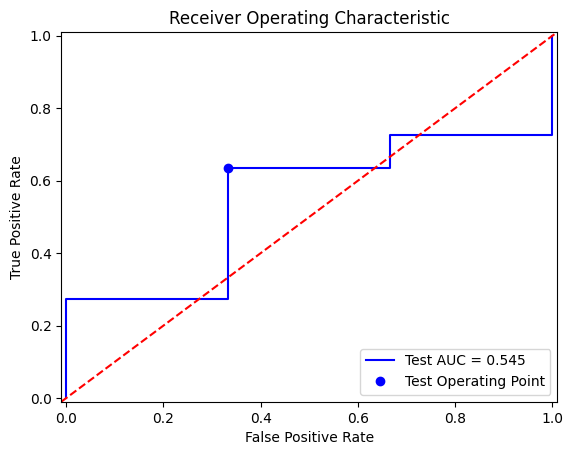

In [21]:
min_limit = -0.01
max_limit = 1.01

operating_point_fpr = fpr_intrp(threshold)
operating_point_tpr = tpr_intrp(threshold)

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.3f' % roc_auc)
plt.plot(operating_point_fpr, operating_point_tpr, 'bo', label=f'Test Operating Point')

plt.plot([min_limit, max_limit], [min_limit, max_limit],'r--')

plt.xlim([min_limit, max_limit])
plt.ylim([min_limit, max_limit])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()